In [62]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


In [63]:
# load 6 modalites data 
from sklearn.utils import resample
import numpy as np
import pandas as pd

def load_data():
    cln_data = pd.read_csv('data/raw_features_cln.csv')
    cnv_data = pd.read_csv('data/raw_features_cnv.csv')
    dna_data = pd.read_csv('data/raw_features_dna.csv')
    mir_data = pd.read_csv('data/raw_features_mir.csv')
    mrna_data = pd.read_csv('data/raw_features_mrna.csv')
    wsi_data = pd.read_csv('data/raw_features_wsi.csv')

    # keep data where all modalities are present based on patient id
    patient_ids = set(cln_data['submitter_id.samples'])
    patient_ids = patient_ids.intersection(set(cnv_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(dna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mir_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mrna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(wsi_data['submitter_id.samples']))

    cln_data = cln_data[cln_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    cnv_data = cnv_data[cnv_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    dna_data = dna_data[dna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mir_data = mir_data[mir_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mrna_data = mrna_data[mrna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    wsi_data = wsi_data[wsi_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)

    # sort data by patient id
    cln_data = cln_data.sort_values('submitter_id.samples').reset_index(drop=True)
    cnv_data = cnv_data.sort_values('submitter_id.samples').reset_index(drop=True)
    dna_data = dna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mir_data = mir_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mrna_data = mrna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    wsi_data = wsi_data.sort_values('submitter_id.samples').reset_index(drop=True)

    # make sure the labels column match for all modalities
    cln_labels = cln_data['label_cln']
    cnv_labels = cnv_data['label_cnv']
    dna_labels = dna_data['label_dna']
    mir_labels = mir_data['label_mir']
    mrna_labels = mrna_data['label_mrna']
    wsi_labels = wsi_data['label_wsi']

    assert np.all(cln_labels == cnv_labels), "Labels mismatch between clinical and CNV data"
    assert np.all(cln_labels == dna_labels), "Labels mismatch between clinical and DNA data"
    assert np.all(cln_labels == mir_labels), "Labels mismatch between clinical and miRNA data"
    assert np.all(cln_labels == mrna_labels), "Labels mismatch between clinical and mRNA data"
    # assert np.all(cln_labels == wsi_labels), "Labels mismatch between clinical and WSI data"

    # drop labels column and patient id column
    cln_data = cln_data.drop(columns=['label_cln', 'submitter_id.samples'])
    cnv_data = cnv_data.drop(columns=['label_cnv', 'submitter_id.samples'])
    dna_data = dna_data.drop(columns=['label_dna', 'submitter_id.samples'])
    mir_data = mir_data.drop(columns=['label_mir', 'submitter_id.samples'])
    mrna_data = mrna_data.drop(columns=['label_mrna', 'submitter_id.samples'])
    wsi_data = wsi_data.drop(columns=['label_wsi', 'submitter_id.samples'])

    # normalize data
    stdscalar = StandardScaler()
    cln_data = stdscalar.fit_transform(cln_data)
    cnv_data = stdscalar.fit_transform(cnv_data)
    dna_data = stdscalar.fit_transform(dna_data)
    mir_data = stdscalar.fit_transform(mir_data)
    mrna_data = stdscalar.fit_transform(mrna_data)
    wsi_data = stdscalar.fit_transform(wsi_data)

    return cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, cln_labels


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

def balance_modality_data(features_list, labels, method='SMOTE'):
    """
    Balances the dataset for each modality separately.
    
    Parameters:
    - features_list: List of feature matrices, one for each modality.
    - labels: Binary labels (numpy array or Series).
    - method: Balancing method ('SMOTE' supported here).
    
    Returns:
    - Separate balanced feature matrices for each modality.
    - Balanced labels (same across all modalities).
    """
    smote = SMOTE(random_state=42)
    balanced_features_list = []
    
    for modality_features in features_list:
        # Balance the current modality's features and labels
        balanced_modality_features, balanced_labels = smote.fit_resample(modality_features, labels)
        balanced_features_list.append(balanced_modality_features)
    
    # Unpack balanced features into separate variables and return them
    return (*balanced_features_list, balanced_labels)

if __name__ == '__main__':
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    
    # List of modalities
    features_list = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    
    # Balance the modalities and unpack them
    balanced_cln_data, balanced_cnv_data, balanced_dna_data, balanced_mir_data, balanced_mrna_data, balanced_wsi_data, balanced_labels = balance_modality_data(features_list, labels, method='SMOTE')
    
    # Print shapes
    print("\nBalanced shapes of modalities:")
    print(f"Clinical: {balanced_cln_data.shape}")
    print(f"CNV: {balanced_cnv_data.shape}")
    print(f"DNA: {balanced_dna_data.shape}")
    print(f"miRNA: {balanced_mir_data.shape}")
    print(f"mRNA: {balanced_mrna_data.shape}")
    print(f"WSI: {balanced_wsi_data.shape}")
    print(f"Labels: {balanced_labels.shape}")

    # Class distribution
    print("\nClass distribution after balancing:")
    print(f"Positive samples: {np.sum(balanced_labels == 1)}")
    print(f"Negative samples: {np.sum(balanced_labels == 0)}")




Balanced shapes of modalities:
Clinical: (1592, 19)
CNV: (1592, 500)
DNA: (1592, 500)
miRNA: (1592, 500)
mRNA: (1592, 500)
WSI: (1592, 800)
Labels: (1592,)

Class distribution after balancing:
Positive samples: 796
Negative samples: 796


In [72]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define a MultimodalDataset class if not already defined
class MultimodalDataset(Dataset):
    def __init__(self, *modalities, labels):
        self.modalities = modalities
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tuple(modality[idx] for modality in self.modalities) + (self.labels[idx],)


def load_and_split_data(modalities, labels, test_size=0.2, random_state=42):
    """
    Splits the data into train and test sets, and balances the test set.
    """
    # Split the data into train and test sets
    train_modalities, test_modalities = [], []
    for modality in modalities:
        train, test = train_test_split(modality, test_size=test_size, random_state=random_state)
        train_modalities.append(train)
        test_modalities.append(test)

    labels_train, labels_test = train_test_split(labels, test_size=test_size, random_state=random_state)

    return train_modalities, test_modalities, labels_train, labels_test

# Function to convert data to tensors
def convert_to_tensors(data):
    return [torch.tensor(modality, dtype=torch.float32) for modality in data]

# Main code
def get_train_test_loader():
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    modalities = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    # cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = balance_modality_data(modalities, labels)
    modalities = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    # Split data
    train_modalities, test_modalities, labels_train, labels_test = load_and_split_data(modalities, labels)

    # Convert data to tensors
    train_tensors = convert_to_tensors(train_modalities)
    test_tensors = convert_to_tensors(test_modalities)
    labels_train = torch.tensor(labels_train, dtype=torch.long)
    labels_test = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = MultimodalDataset(*train_tensors, labels=labels_train)
    test_dataset = MultimodalDataset(*test_tensors, labels=labels_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Run the main function
train_loader, test_loader = get_train_test_loader()


In [65]:
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers):
        super(ModalityEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim) or (batch_size, input_dim).
        Returns:
            Encoded tensor of shape (seq_len, batch_size, embed_dim).
        """
        # If input is 2D (batch_size, input_dim), add a dummy seq_len dimension
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Shape becomes (batch_size, 1, input_dim)
        
        # Embed and transpose for Transformer
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch_size, embed_dim)
        
        # Pass through the Transformer
        x = self.transformer(x)
        return x

In [66]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, query, key, value):
        """
        Args:
            query: Tensor of shape (seq_len, batch_size, embed_dim).
            key, value: Tensors of shape (seq_len, batch_size, embed_dim).
        Returns:
            Fused representation of shape (seq_len, batch_size, embed_dim).
        """
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

In [67]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, matthews_corrcoef, average_precision_score, confusion_matrix

# Function to evaluate the model
def test_model(model, test_loader, device="cpu"):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            # Unpack modalities and labels from the batch
            modalities = [modality.to(device) for modality in batch[:-1]]
            labels = batch[-1].to(device)

            # Forward pass
            outputs = model(modalities)
            probs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid for binary classification probabilities

            # Predictions (threshold at 0.5)
            preds = (probs >= 0.52).long()

            # Collect predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    mcc = matthews_corrcoef(all_targets, all_preds)
    auprc = average_precision_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)
    specificity = cm[0, 0] / cm[0, :].sum()  

    print("Test Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"AUPRC: {auprc:.4f}")

    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        "accuracy": accuracy,
        "auc": auc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "mcc": mcc,
        "auprc": auprc
    }

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


# Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, input_dims, embed_dim, num_heads, num_layers):
        super(MultimodalModel, self).__init__()
        
        # Modality encoders for each input
        self.modality_encoders = nn.ModuleList([
            ModalityEncoder(input_dim, embed_dim, num_heads, num_layers) for input_dim in input_dims
        ])
        
        # Cross-attention layer
        self.cross_attention = CrossAttentionLayer(embed_dim, num_heads)
        
        # Final classification head
        self.classification_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1),  # Output 1 value per sample (for binary classification)
            nn.Sigmoid()  # Sigmoid activation for BCE loss
        )
    
    def forward(self, modalities):
        """
        Args:
            modalities: List of tensors, one for each modality.
                        Each tensor should have shape (batch_size, seq_len, input_dim)
                        or (batch_size, input_dim).
        Returns:
            Predictions: Tensor of shape (batch_size, 1).
        """
        # Encode each modality
        encoded_modalities = [encoder(modality) for encoder, modality in zip(self.modality_encoders, modalities)]

        # Apply cross-attention between modalities
        query = encoded_modalities[0]  # Use the first modality as query
        keys_values = torch.cat(encoded_modalities[1:], dim=0)  # Concatenate other modalities

        fused_representation = self.cross_attention(query, keys_values, keys_values)

        # Aggregate (e.g., by mean pooling over sequence dimension)
        aggregated_representation = fused_representation.mean(dim=0)

        # Output final classification prediction
        predictions = self.classification_head(aggregated_representation)
        return predictions


# Training function
def train_model(model, train_loader, optimizer, num_epochs, device="cpu"):
    """
    Train the multimodal model using Binary Cross-Entropy Loss.
    Args:
        model: The multimodal model.
        train_loader: DataLoader for the training set.
        optimizer: Optimizer for the model.
        num_epochs: Number of training epochs.
        device: Device to train the model on ('cpu' or 'cuda').
    """
    model.to(device)
    model.train()

    criterion = nn.BCELoss(reduction='none')  # Compute per-sample loss first


    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move batch data to the device
            modalities = [modality.to(device) for modality in batch[:-1]]
            labels = batch[-1].to(device)  # Binary labels

            # Forward pass
            optimizer.zero_grad()
            predictions = model(modalities).squeeze()  # Remove extra dimensions

            # Compute BCE loss
            # Compute BCE loss per sample
            loss = criterion(predictions, labels.float())

            # Apply class weights based on labels
            class_weights = torch.tensor([5.0, 1.0]).to(device)  # Adjust weights for class imbalance
            sample_weights = torch.where(labels == 1, class_weights[1], class_weights[0])
            loss = (loss * sample_weights).mean()  # Apply weights and compute mean loss


            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        test_model(model, train_loader, device=device)
        # test_model(model, test_loader, device=device)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/10: 100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch 1/10, Loss: 1.1986
Test Metrics:
Accuracy: 0.9018
AUC: 0.9439
F1 Score: 0.9027
Precision: 0.8923
Recall: 0.9134
Specificity: 0.8903
MCC: 0.8038
AUPRC: 0.9368


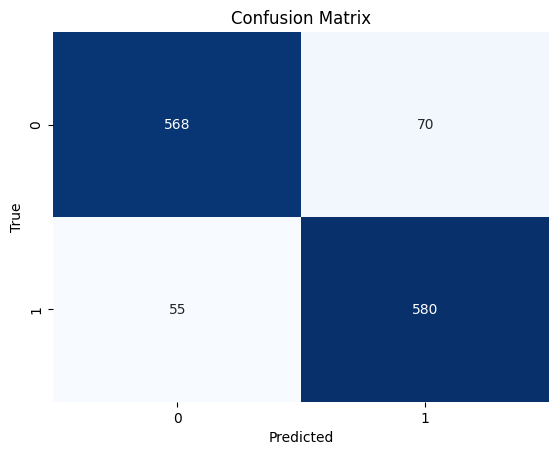

Epoch 2/10: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s]


Epoch 2/10, Loss: 0.7008
Test Metrics:
Accuracy: 0.9395
AUC: 0.9722
F1 Score: 0.9392
Precision: 0.9415
Recall: 0.9370
Specificity: 0.9420
MCC: 0.8790
AUPRC: 0.9664


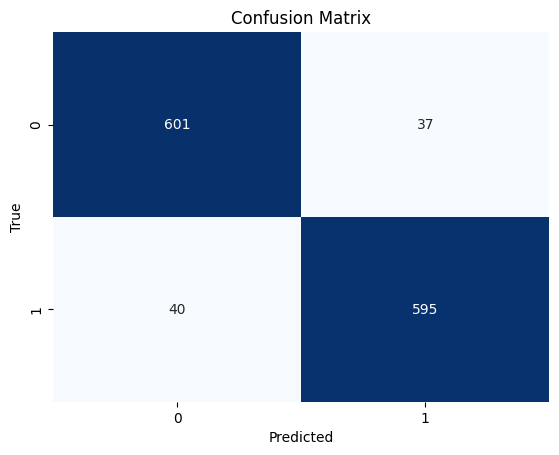

Epoch 3/10: 100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 3/10, Loss: 0.5305
Test Metrics:
Accuracy: 0.9403
AUC: 0.9792
F1 Score: 0.9393
Precision: 0.9530
Recall: 0.9260
Specificity: 0.9545
MCC: 0.8809
AUPRC: 0.9750


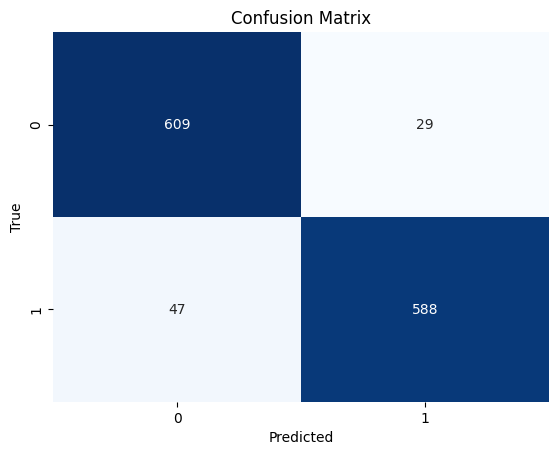

Epoch 4/10: 100%|██████████| 40/40 [00:02<00:00, 14.34it/s]


Epoch 4/10, Loss: 0.4798
Test Metrics:
Accuracy: 0.9466
AUC: 0.9853
F1 Score: 0.9471
Precision: 0.9355
Recall: 0.9591
Specificity: 0.9342
MCC: 0.8935
AUPRC: 0.9845


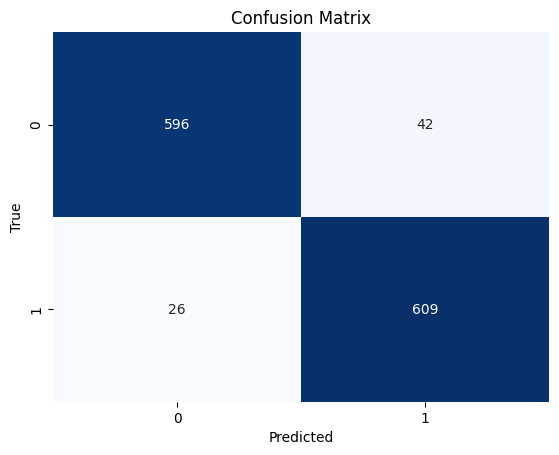

Epoch 5/10: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s]


Epoch 5/10, Loss: 0.4582
Test Metrics:
Accuracy: 0.9301
AUC: 0.9749
F1 Score: 0.9295
Precision: 0.9347
Recall: 0.9244
Specificity: 0.9357
MCC: 0.8602
AUPRC: 0.9775


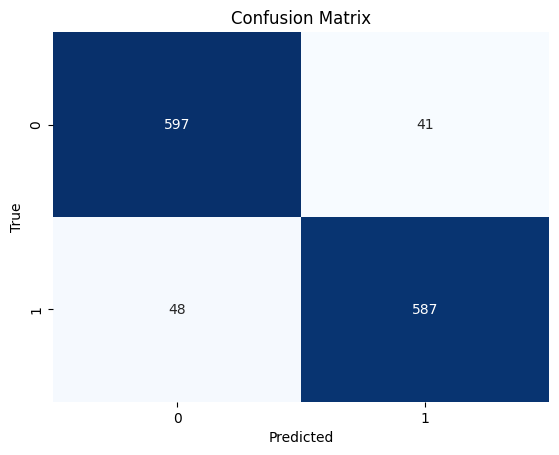

Epoch 6/10: 100%|██████████| 40/40 [00:02<00:00, 13.58it/s]


Epoch 6/10, Loss: 0.5090
Test Metrics:
Accuracy: 0.9427
AUC: 0.9810
F1 Score: 0.9426
Precision: 0.9418
Recall: 0.9433
Specificity: 0.9420
MCC: 0.8853
AUPRC: 0.9803


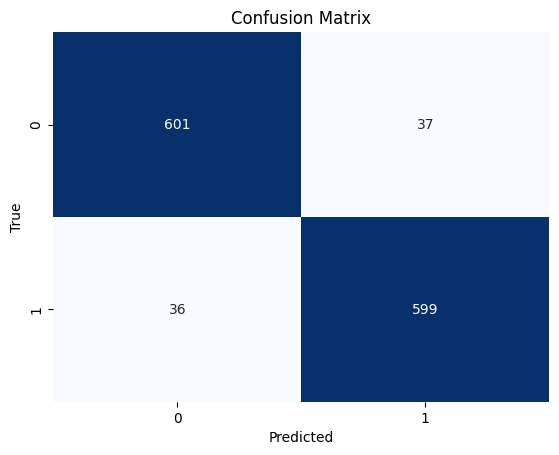

Epoch 7/10: 100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 7/10, Loss: 0.3653
Test Metrics:
Accuracy: 0.9592
AUC: 0.9883
F1 Score: 0.9591
Precision: 0.9591
Recall: 0.9591
Specificity: 0.9592
MCC: 0.9183
AUPRC: 0.9912


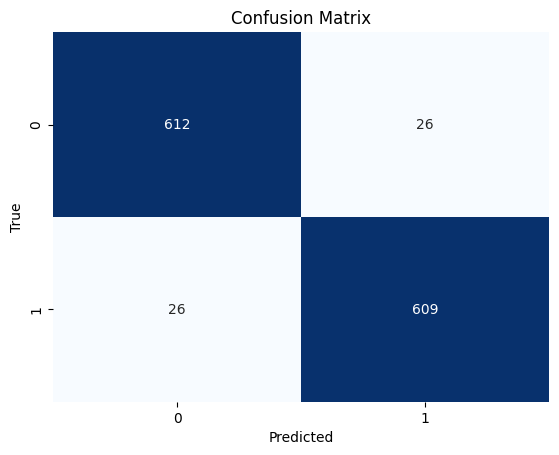

Epoch 8/10: 100%|██████████| 40/40 [00:03<00:00, 12.84it/s]


Epoch 8/10, Loss: 0.3065
Test Metrics:
Accuracy: 0.9623
AUC: 0.9895
F1 Score: 0.9612
Precision: 0.9884
Recall: 0.9354
Specificity: 0.9890
MCC: 0.9259
AUPRC: 0.9888


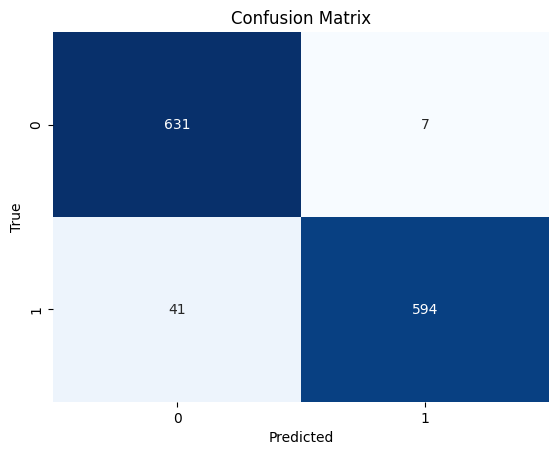

Epoch 9/10: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s]


Epoch 9/10, Loss: 0.2703
Test Metrics:
Accuracy: 0.9717
AUC: 0.9953
F1 Score: 0.9711
Precision: 0.9918
Recall: 0.9512
Specificity: 0.9922
MCC: 0.9442
AUPRC: 0.9965


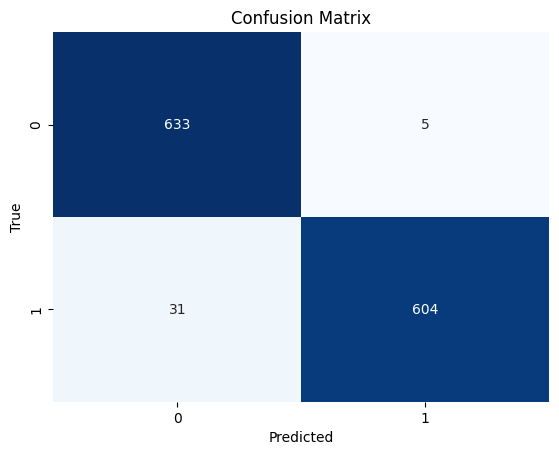

Epoch 10/10: 100%|██████████| 40/40 [00:02<00:00, 14.65it/s]


Epoch 10/10, Loss: 0.2518
Test Metrics:
Accuracy: 0.9701
AUC: 0.9949
F1 Score: 0.9704
Precision: 0.9599
Recall: 0.9811
Specificity: 0.9592
MCC: 0.9405
AUPRC: 0.9958


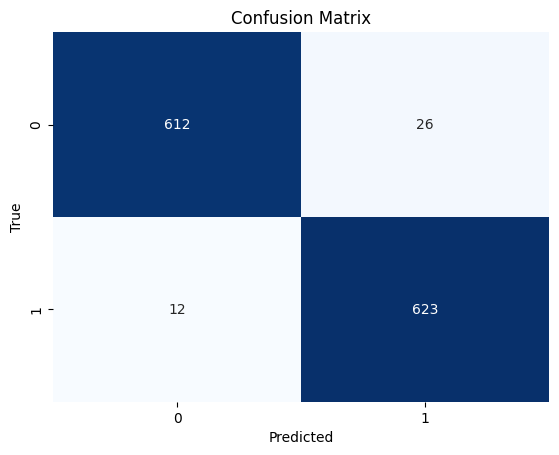

Test Metrics:
Accuracy: 0.7367
AUC: 0.8060
F1 Score: 0.7273
Precision: 0.7619
Recall: 0.6957
Specificity: 0.7785
MCC: 0.4756
AUPRC: 0.8274


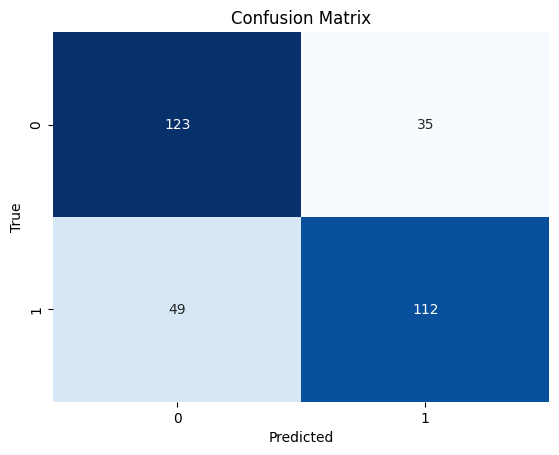

In [69]:
# Example usage
def main_training():
    # Load data
    train_loader, test_loader = get_train_test_loader()  # Assuming your main() function loads data and returns DataLoaders

    # Model parameters
    input_dims = [19, 500, 500, 500, 500, 800]  # Number of features for each modality
    embed_dim = 128  # Common embedding dimension
    num_heads = 4  # Number of attention heads
    num_layers = 2  # Number of layers in the transformer encoders

    # Initialize model, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultimodalModel(input_dims, embed_dim, num_heads, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train the model
    num_epochs = 10
    train_model(model, train_loader, optimizer, num_epochs, device)

    metrics = test_model(model, test_loader, device)


if __name__ == "__main__":
    main_training()

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define the Modality Encoder
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers):
        super(ModalityEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.input_proj(x)
        return self.transformer(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, query, key, value):
        """
        Args:
            query: Tensor of shape (seq_len, batch_size, embed_dim).
            key, value: Tensors of shape (seq_len, batch_size, embed_dim).
        Returns:
            Fused representation of shape (seq_len, batch_size, embed_dim).
        """
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

# Define the full model
class MultimodalModel(nn.Module):
    def __init__(self, input_dims, embed_dim, num_heads, num_layers):
        super(MultimodalModel, self).__init__()
        self.modality_encoders = nn.ModuleList([
            ModalityEncoder(input_dim, embed_dim, num_heads, num_layers) for input_dim in input_dims
        ])
        self.cross_attention = CrossAttentionLayer(embed_dim, num_heads)
        self.classification_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, modalities, return_embeddings=False):
        # Encode each modality
        encoded_modalities = [encoder(modality) for encoder, modality in zip(self.modality_encoders, modalities)]

        if return_embeddings:
            return encoded_modalities  # Return embeddings for contrastive loss

        # Apply cross-attention
        query = encoded_modalities[0]
        keys_values = torch.cat(encoded_modalities[1:], dim=0)
        fused_representation = self.cross_attention(query, keys_values, keys_values)
        
        predictions = self.classification_head(fused_representation)
        return predictions

# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings1, embeddings2, labels):
        distances = F.pairwise_distance(embeddings1, embeddings2)
        loss = labels * distances.pow(2) + (1 - labels) * F.relu(self.margin - distances).pow(2)
        return loss.mean()

# Training function
def train_model_with_contrastive_loss(model, train_loader, optimizer, contrastive_loss_fn, num_epochs, device="cpu"):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move batch data to the device
            modalities = [modality.to(device) for modality in batch[:-1]]
            labels = batch[-1].to(device)  # Binary labels

            # Forward pass through encoders
            optimizer.zero_grad()
            encoded_modalities = [encoder(modality) for encoder, modality in zip(model.modality_encoders, modalities)]

            # Compute contrastive loss for each pair of modalities
            contrastive_loss = 0
            for i in range(len(encoded_modalities)):
                for j in range(len(encoded_modalities)):
                    if i == j:
                        continue

                    embeddings1 = encoded_modalities[i].mean(dim=0)  # Aggregate over sequence dim
                    embeddings2 = encoded_modalities[j].mean(dim=0)

                    # Create labels for pairs: 1 for similar (positive-positive, negative-negative), 0 for dissimilar
                    pair_labels = (labels[i] == labels[j]).float()
                    contrastive_loss += contrastive_loss_fn(embeddings1, embeddings2, pair_labels)

            # Combine contrastive loss with classification loss
            predictions = model(modalities).squeeze(-1)  # Only remove the last dimension if it's 1
            labels = labels.view(-1)  # Ensure labels are flat
            # Compute classification loss
            classification_loss = F.binary_cross_entropy(predictions, labels.float())

            loss = contrastive_loss + classification_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

train_loader, test_loader = get_train_test_loader()  # Assuming your main() function loads data and returns DataLoaders

# Model parameters
input_dims = [19, 500]
embed_dim = 128
num_heads = 4
num_layers = 2
num_epochs = 20



# Initialize model, optimizer, and loss function
model = MultimodalModel(input_dims, embed_dim, num_heads, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
contrastive_loss_fn = ContrastiveLoss(margin=1.0)

# Train the model
train_model_with_contrastive_loss(model, train_loader, optimizer, contrastive_loss_fn, num_epochs, device="cuda" if torch.cuda.is_available() else "cpu")


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/20: 100%|██████████| 40/40 [00:02<00:00, 19.01it/s]


Epoch 1/20, Loss: 19.9785


Epoch 2/20: 100%|██████████| 40/40 [00:01<00:00, 22.09it/s]


Epoch 2/20, Loss: 2.8506


Epoch 3/20: 100%|██████████| 40/40 [00:01<00:00, 23.03it/s]


Epoch 3/20, Loss: 2.1773


Epoch 4/20: 100%|██████████| 40/40 [00:01<00:00, 22.14it/s]


Epoch 4/20, Loss: 2.1318


Epoch 5/20: 100%|██████████| 40/40 [00:01<00:00, 22.91it/s]


Epoch 5/20, Loss: 1.9762


Epoch 6/20: 100%|██████████| 40/40 [00:02<00:00, 17.68it/s]


Epoch 6/20, Loss: 2.1087


Epoch 7/20: 100%|██████████| 40/40 [00:01<00:00, 22.08it/s]


Epoch 7/20, Loss: 2.3999


Epoch 8/20: 100%|██████████| 40/40 [00:02<00:00, 19.78it/s]


Epoch 8/20, Loss: 2.1049


Epoch 9/20: 100%|██████████| 40/40 [00:02<00:00, 19.92it/s]


Epoch 9/20, Loss: 2.2047


Epoch 10/20: 100%|██████████| 40/40 [00:01<00:00, 22.60it/s]


Epoch 10/20, Loss: 2.1033


Epoch 11/20: 100%|██████████| 40/40 [00:01<00:00, 22.34it/s]


Epoch 11/20, Loss: 1.6458


Epoch 12/20: 100%|██████████| 40/40 [00:01<00:00, 23.34it/s]


Epoch 12/20, Loss: 2.1789


Epoch 13/20: 100%|██████████| 40/40 [00:01<00:00, 23.80it/s]


Epoch 13/20, Loss: 1.4404


Epoch 14/20: 100%|██████████| 40/40 [00:01<00:00, 22.88it/s]


Epoch 14/20, Loss: 1.6441


Epoch 15/20: 100%|██████████| 40/40 [00:02<00:00, 19.79it/s]


Epoch 15/20, Loss: 1.5396


Epoch 16/20: 100%|██████████| 40/40 [00:01<00:00, 22.88it/s]


Epoch 16/20, Loss: 1.5812


Epoch 17/20: 100%|██████████| 40/40 [00:01<00:00, 23.79it/s]


Epoch 17/20, Loss: 1.7500


Epoch 18/20: 100%|██████████| 40/40 [00:01<00:00, 23.76it/s]


Epoch 18/20, Loss: 2.1221


Epoch 19/20: 100%|██████████| 40/40 [00:01<00:00, 22.64it/s]


Epoch 19/20, Loss: 1.3704


Epoch 20/20: 100%|██████████| 40/40 [00:01<00:00, 23.82it/s]

Epoch 20/20, Loss: 1.6553


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 104.07it/s]


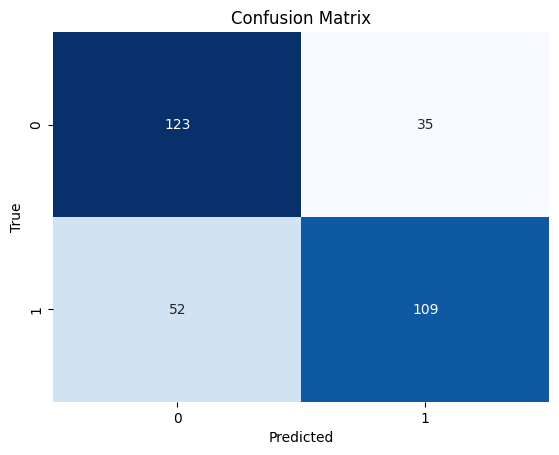

Test Loss: 0.9905, Accuracy: 0.7273
AUC: 0.7929, F1 Score: 0.7148


In [71]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_model(model, test_loader, contrastive_loss_fn=None, device="cpu"):
    model.to(device)
    model.eval()

    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move batch data to the device
            modalities = [modality.to(device) for modality in batch[:-1]]
            labels = batch[-1].to(device)  # Binary labels

            # Forward pass through the model
            predictions = model(modalities).squeeze(-1)  # Remove last dimension if it's 1

            # Compute classification loss
            labels = labels.view(-1)  # Ensure labels are flat
            classification_loss = F.binary_cross_entropy(predictions, labels.float())
            total_loss += classification_loss.item()

            # Calculate accuracy
            predicted_classes = (predictions > 0.5).float()
            total_correct += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and labels for further evaluation
            all_predictions.extend(predictions.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            # If contrastive loss is needed for evaluation (optional):
            if contrastive_loss_fn:
                encoded_modalities = [encoder(modality) for encoder, modality in zip(model.modality_encoders, modalities)]
                contrastive_loss = 0
                for i in range(len(encoded_modalities)):
                    for j in range(len(encoded_modalities)):
                        if i == j:
                            continue
                        embeddings1 = encoded_modalities[i].mean(dim=0)
                        embeddings2 = encoded_modalities[j].mean(dim=0)
                        pair_labels = (labels[i] == labels[j]).float()
                        contrastive_loss += contrastive_loss_fn(embeddings1, embeddings2, pair_labels)
                total_loss += contrastive_loss.item()

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    auc = roc_auc_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, [int(p > 0.5) for p in all_predictions])
    cm = confusion_matrix(all_labels, [int(p > 0.5) for p in all_predictions])

    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}, F1 Score: {f1:.4f}")

    return all_predictions, all_labels, avg_loss, accuracy


# Run the evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"
all_predictions, all_labels, avg_loss, accuracy = evaluate_model(
    model, test_loader, contrastive_loss_fn, device=device
)